# Load all libraries and data

In [16]:
#pip install optuna

In [17]:
#pip install shap

In [18]:
#pip install graphviz

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

import graphviz
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import optuna
from optuna.trial import Trial
from functools import partial

import shap

In [2]:
# Some constants
random_state = 123
n_trials = 50

In [3]:
pd.set_option('display.max_columns', None) # display all columns without any truncation in Data Frames
pd.set_option('use_inf_as_na', True) # treat infinity as missing value in Data Frames

In [4]:
# An only way, how I managed to work with the given file was to load it to google drive and then open via colab
# That is why I need to connect to my google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
path_to_file = 'gdrive/MyDrive/Colab Notebooks/dataset.pkl'
df = pd.read_pickle(path_to_file)

In [6]:
df.head()

actq      apq        atq       ceqq      cheq  \
date       ticker                                                      
2000-02-01 LLB        3.540    0.143      7.668      6.732     2.553   
2000-02-03 MYR      107.661   24.387    220.463    136.555     1.049   
2000-02-08 LZB      447.719   57.893    740.905    460.612    16.531   
           SJM      234.415   33.821    488.136    322.432    26.054   
2000-02-09 CSCO    7722.000  482.000  21391.000  16523.000  3968.000   

                      cogsq     csh12q    cshfdq     cshiq  cshopq     cshoq  \
date       ticker                                                              
2000-02-01 LLB        0.458     6.3910     6.391     6.989     0.0     6.268   
2000-02-03 MYR       36.883    25.5360    22.082    28.458     0.0    20.379   
2000-02-08 LZB      274.525    52.2660    52.274    52.544     0.0    52.544   
           SJM       91.172    28.8808    28.603    32.425     0.0    28.539   
2000-02-09 CSCO    1422.000  3374.1250  3648.000  3445.000     0.0  3445.000   

                     cshprq   cstkq   dlcq    dlttq      dpq  dvpq  epsf12  \
date       ticker                                                            
2000-02-01 LLB        6.055   0.070  0.023    0.000    0.055   0.0   -0.03   
2000-02-03 MYR       22.081   0.003  0.000   24.424    1.588   0.0   -0.43   
2000-02-08 LZB       52.088  52.544  2.473  123.247    6.833   0.0    1.53   
           SJM       28.544   7.135    NaN   75.000    4.765   0.0    1.22   
2000-02-09 CSCO    3413.000   3.445  0.000    0.000  164.000   0.0    0.68   

                   epsfi12  epsfiq  epsfxq  epspi12  epspiq  epspxq  epsx12  \
date       ticker                                                             
2000-02-01 LLB       -0.03   -0.07   -0.07    -0.03   -0.07   -0.07   -0.03   
2000-02-03 MYR       -0.20    0.11    0.21    -0.20    0.11    0.21   -0.43   
2000-02-08 LZB        1.53    0.41    0.41     1.54    0.41    0.41    1.54   
           SJM        1.22    0.17    0.17     1.23    0.17    0.17    1.23   
2000-02-09 CSCO       0.68    0.23    0.23     0.73    0.24    0.24    0.73   

                   ibadj12   ibadjq   ibcomq      ibq     icaptq    invtq  \
date       ticker                                                           
2000-02-01 LLB         NaN   -0.426   -0.426   -0.426      6.732    0.000   
2000-02-03 MYR         NaN    4.690    4.690    4.690    160.979   78.640   
2000-02-08 LZB         NaN   21.337   21.337   21.337    583.859  128.785   
           SJM         NaN    4.963    4.963    4.963    397.432  140.247   
2000-02-09 CSCO        NaN  816.000  816.000  816.000  16568.000  695.000   

                       lctq       ltq  mibq  miiq      niq    nopiq  oepf12  \
date       ticker                                                             
2000-02-01 LLB        0.936     0.936   0.0   0.0   -0.426    0.039   -0.03   
2000-02-03 MYR       42.543    83.908   0.0   0.0    2.517   -0.924   -0.43   
2000-02-08 LZB      134.964   280.293   0.0   0.0   21.337    1.637    1.53   
           SJM       68.806   165.704   0.0   0.0    4.963    0.751    1.33   
2000-02-09 CSCO    3778.000  4823.000  45.0   NaN  816.000  120.000    0.77   

                   oeps12  oepsxq    oiadpq    oibdpq  opepsq  optdrq  \
date       ticker                                                       
2000-02-01 LLB      -0.03   -0.07    -0.465    -0.410   -0.07     NaN   
2000-02-03 MYR      -0.43    0.21     6.421     8.009    0.21     NaN   
2000-02-08 LZB       1.54    0.41    33.288    40.121    0.41     NaN   
           SJM       1.34    0.28    13.054    17.819    0.28     NaN   
2000-02-09 CSCO      0.82    0.23  1089.000  1253.000    0.24     NaN   

                        piq    ppentq  prcraq  pstkq  pstkrq     rectq  \
date       ticker                                                        
2000-02-01 LLB       -0.426     1.182     NaN    0.0     0.0     0.611   
2000-02-03 MYR        4.690 

# Prepare the data frame as we did during the lectures

## Fill missing values

In [7]:
data = df.groupby('ticker').fillna(method = 'ffill').fillna(method = "bfill") # forward-fill and backward-fill of data grouped by ticker
data = data.fillna(0) # fill all other missing values with 0

## Remove the data that we do not need

In [8]:
# Delete columns containing 'fqtr'
data = data.drop([x  for x in df.columns if 'fqtr' in x], axis=1)

In [9]:
# Restrict only to companies with Market Cap > 1000
data = data[data['market_cap'] > 1000]

## Make date the index

In [10]:
data.reset_index(inplace=True)
data.set_index('date',inplace=True)
data.head()

,ticker,actq,apq,atq,ceqq,cheq,cogsq,csh12q,cshfdq,cshiq,cshopq,cshoq,cshprq,cstkq,dlcq,dlttq,dpq,dvpq,epsf12,epsfi12,epsfiq,epsfxq,epspi12,epspiq,epspxq,epsx12,ibadj12,ibadjq,ibcomq,ibq,icaptq,invtq,lctq,ltq,mibq,miiq,niq,nopiq,oepf12,oeps12,oepsxq,oiadpq,oibdpq,opepsq,optdrq,piq,ppentq,prcraq,pstkq,pstkrq,rectq,req,revtq,saleq,seqq,spiq,teqq,txdbq,txditcq,txpq,txtq,xintq,xoprq,xrdq,xsgaq,capxy,cdvcy,chechy,cogsy,dlcchy,dltisy,dltry,dpcy,dvy,ibcomy,ibcy,miiy,oancfy,oepsxy,oibdpy,revty,txpdy,xidocy,xidoy,xinty,xrdy,xsgay,dvpspq,prccq,beq,bmq,book_value_per_share,book_value_yield,market_cap,buy_back_yield,yearly_sales,evmq,pe_op_basicq,pe_op_dilq,pe_exiq,capeiq,pe_incq,psq,oancfy_q,opcfq,cfo-per-share,cf_yield,pcfq,dvq,dprq,npmq,opmbdq,opmadq,gpmq,ptpmq,ibcq,dpcq,cfmq,at4,roaq,roceq,efftaxq,ceq4,seq4,lctq4,be4,lagbe4,lagseq4,lagicapt4,lagppent4,lagppent_alt4,roeq,aftret_eqq,aftret_invcapxq,aftret_equityq,pretret_noaq,pretret_earnatq,gprofq,equity_invcapq,debt_invcapq,totdebt_invcapq,capital_ratioq,int_debtq,int_totdebtq,cash_ltq,invt_actq,rect_actq,debt_atq,debt_ebitdaq,short_debtq,curr_debtq,lt_debtq,profit_lctq,ocf_lctq,capxq,fcf_ocfq,fcf_csfhdq,fcf_yield,cash_debtq,lt_ppentq,dltt_beq,debt_assetsq,debt_capitalq,de_ratioq,intcovq,intcov_ratioq,cash_ratioq,quick_ratioq,curr_ratioq,cash_conversionq,inv_turnq,at_turnq,rect_turnq,pay_turnq,sale_invcapq,sale_equityq,sale_nwcq,rd_saleq,at5,accrualq,return,cum_ret,spy_cum_ret,next_period_return,spy_next_period_return,pred_rel_return,sic_100,sic_200,sic_700,sic_800,sic_900,sic_1000,sic_1040,sic_1044,sic_1090,sic_1220,sic_1221,sic_1311,sic_1381,sic_1382,sic_1389,sic_1400,sic_1520,sic_1531,sic_1540,sic_1600,sic_1623,sic_1700,sic_1731,sic_2000,sic_2011,sic_2013,sic_2015,sic_2020,sic_2024,sic_2030,sic_2033,sic_2040,sic_2050,sic_2052,sic_2060,sic_2070,sic_2080,sic_2082,sic_2084,sic_2085,sic_2086,sic_2090,sic_2092,sic_2100,sic_2111,sic_2200,sic_2211,sic_2221,sic_2250,sic_2273,sic_2300,sic_2320,sic_2330,sic_2340,sic_2400,sic_2421,sic_2430,sic_2451,sic_2452,sic_2510,sic_2511,sic_2520,sic_2522,sic_2531,sic_2540,sic_2590,sic_2611,sic_2621,sic_2631,sic_2650,sic_2670,sic_2673,sic_2711,sic_2721,sic_2731,sic_2732,sic_2741,sic_2750,sic_2761,sic_2780,sic_2790,sic_2800,sic_2810,sic_2820,sic_2821,sic_2833,sic_2834,sic_2835,sic_2836,sic_2840,sic_2842,sic_2844,sic_2851,sic_2860,sic_2870,sic_2890,sic_2891,sic_2911,sic_2950,sic_2990,sic_3011,sic_3021,sic_3050,sic_3060,sic_3080,sic_3081,sic_3086,sic_3089,sic_3100,sic_3140,sic_3220,sic_3221,sic_3241,sic_3250,sic_3260,sic_3270,sic_3272,sic_3281,sic_3290,sic_3310,sic_3312,sic_3317,sic_3330,sic_3334,sic_3341,sic_3350,sic_3357,sic_3390,sic_3411,sic_3420,sic_3430,sic_3440,sic_3442,sic_3443,sic_3444,sic_3448,sic_3452,sic_3460,sic_3470,sic_3480,sic_3490,sic_3510,sic_3523,sic_3530,sic_3531,sic_3532,sic_3533,sic_3537,sic_3540,sic_3541,sic_3550,sic_3555,sic_3559,sic_3560,sic_3561,sic_3562,sic_3564,sic_3567,sic_3569,sic_3570,sic_3571,sic_3572,sic_3575,sic_3576,sic_3577,sic_3578,sic_3579,sic_3580,sic_3585,sic_3590,sic_3600,sic_3612,sic_3613,sic_3620,sic_3621,sic_3630,sic_3634,sic_3640,sic_3651,sic_3652,sic_3661,sic_3663,sic_3669,sic_3670,sic_3672,sic_3674,sic_3677,sic_3678,sic_3679,sic_3690,sic_3695,sic_3711,sic_3713,sic_3714,sic_3715,sic_3716,sic_3721,sic_3724,sic_3728,sic_3730,sic_3743,sic_3751,sic_3760,sic_3790,sic_3812,sic_3821,sic_3822,sic_3823,sic_3824,sic_3825,sic_3826,sic_3827,sic_3829,sic_3841,sic_3842,sic_3843,sic_3844,sic_3845,sic_3851,sic_3861,sic_3873,sic_3910,sic_3911,sic_3931,sic_3942,sic_3944,sic_3949,sic_3950,sic_3960,sic_3990,sic_4011,sic_4100,sic_4210,sic_4213,sic_4220,sic_4400,sic_4412,sic_4512,sic_4513,sic_4522,sic_4581,sic_4610,sic_4700,sic_4731,sic_4812,sic_4813,sic_4822,sic_4832,sic_4833,sic_4841,sic_4888,sic_4899,sic_4911,sic_4922,sic_4923,sic_4924,sic_4931,sic_4932,sic_4941,sic_4950,sic_4953,sic_4955,sic_4991,sic_5000,sic_5010,sic_5013,sic_5030,sic_5031,sic_5040,sic_5045,sic_5047,sic_5051,sic_5063,sic_5065,sic_5070,sic_5072,sic_5080,sic_5084,si

# 1. Create a target feature, where the entries are $1$ if the stock outperforms SPY by more than $5$% in the earnings period and $-1$ if it underperforms by $-10$%, and $0$ if the performance is between these values.

In [11]:
def create_target_feature(x):
    if x > 0.05:
        return 1
    elif x <= -0.1:
        return -1
    else:
        return 0

In [12]:
data['rel_performance'] = data['pred_rel_return'].apply(create_target_feature)
data['rel_performance'].head()

date
2000-02-09    0
2000-02-09    1
2000-02-10    1
2000-02-11    1
2000-02-15    0
Name: rel_performance, dtype: int64

In [13]:
# Review how many there are values in each group
data['rel_performance'].value_counts()

 0    49392
 1    40737
-1    21339
Name: rel_performance, dtype: int64

# 2.  Come up with a classification model to predict a target above. Create both a DecisionTree classifier and a BaggingClassifier and use Optuna to find optimal hyperparameters.

## Create train, validation and test datasets

In [14]:
columns_to_delete = ['ticker','date','next_period_return','spy_next_period_return',
                     'rel_performance','pred_rel_return','return', 'cum_ret', 'spy_cum_ret']

In [15]:
# For the first try let us just use the daterange from the lecture
df_train = data.loc['2000':'2002']
df_valid = data.loc['2003-04-01':'2003-07-01']
df_test = data.loc['2003-07-01':'2003-10-01']

In [16]:
# Data for further processing
train = df_train.reset_index().drop(columns_to_delete, axis=1)
valid = df_valid.reset_index().drop(columns_to_delete, axis=1)
test = df_test.reset_index().drop(columns_to_delete, axis=1)

# Returns
train_stock_returns = df_train['next_period_return']
valid_stock_returns = df_valid['next_period_return']
test_stock_returns = df_test['next_period_return']

# Target columns
y_train = df_train['rel_performance'].values
y_valid = df_valid['rel_performance'].values
y_test = df_test['rel_performance'].values

In [17]:
# Scale the features
scaler = StandardScaler()
float_vars = [x for x in train.columns if data[x].dtype == 'float64']

train[float_vars] = scaler.fit_transform(train[float_vars])
valid[float_vars] = scaler.transform(valid[float_vars])
test[float_vars] = scaler.transform(test[float_vars])

In [18]:
train.shape

(10044, 721)

## All objective functions to be used for optuna trainings

In [19]:
def objective_for_DT(trial:Trial, train=None, labels=None, val=None, val_labels=None, val_rets=None):

    min_samples_leaf = trial.suggest_int('min_samples_leaf', 200, 1000, step=100)
    max_depth = trial.suggest_int('max_depth', 5, 25, step=5)

    DT_clf = DecisionTreeClassifier(min_samples_leaf = min_samples_leaf,
                                   max_depth = max_depth,
                                   random_state = random_state)
    DT_clf.fit(train, labels)
    preds = DT_clf.predict(val)
    profit = (preds * val_rets).sum()
    return profit

In [20]:
def objective_for_LR(trial:Trial, train=None, labels=None, val=None, val_labels=None, val_rets=None):

      l1_ratio = trial.suggest_float("l1_ratio", 0, 1, step = 0.01)

      LR_clf = LogisticRegression(l1_ratio = l1_ratio, random_state = random_state)

      LR_clf.fit(train, labels)
      preds = LR_clf.predict(val)
      profit = (preds * val_rets).sum()
      return profit

In [21]:
def objective_for_BG(trial:Trial, train=None, labels=None, val=None, val_labels=None, val_rets=None):

    min_samples_leaf = trial.suggest_int('min_samples_leaf', 200, 1000, step=100)
    max_depth = trial.suggest_int('max_depth', 5, 25, step=5)
    max_samples = trial.suggest_int('max_samples', 50, 1000, step=50)
    n_estimators = trial.suggest_int('n_estimators', 10, 50, step=5)

    BG_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf = min_samples_leaf, max_depth = max_depth),
                               n_estimators = n_estimators, max_samples = max_samples, random_state = random_state)
    BG_clf.fit(train, labels)
    preds = BG_clf.predict(val)
    profit = (preds * val_rets).sum()
    return profit

## Train Decision Tree classifier

In [22]:
DT_clf = DecisionTreeClassifier(min_samples_leaf = 600, max_depth = 8, random_state = random_state)
DT_clf.fit(train, y_train)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=600, random_state=123)

In [23]:
# Review how the tree looks like
dot_data = tree.export_graphviz(DT_clf, out_file = None)
graph = graphviz.Source(dot_data)
graph.render('tree_1')

'tree_1.pdf'

In [24]:
# Review the accuracy of the model
DT_train_accuracy = accuracy_score(y_train, DT_clf.predict(train))
DT_valid_accuracy = accuracy_score(y_valid, DT_clf.predict(valid))

print("Train accuracy:", DT_train_accuracy)
print("Validation accuracy:", DT_valid_accuracy)

Train accuracy: 0.5288729589804858
Validation accuracy: 0.45828295042321643


The accuracy is different from the one that we received during the lecture, because a target feature was created differently.

In [25]:
study1 = optuna.create_study(direction="maximize")
study1.optimize(partial(objective_for_DT, train=train, labels=y_train, val=valid, val_labels=y_valid, val_rets=valid_stock_returns.values), n_trials=n_trials, n_jobs=-1)

[I 2023-12-10 22:57:20,368] A new study created in memory with name: no-name-081b025a-a107-478c-b9c1-5f5913315976
[I 2023-12-10 22:57:21,284] Trial 0 finished with value: 128.486343 and parameters: {'min_samples_leaf': 900, 'max_depth': 20}. Best is trial 0 with value: 128.486343.
[I 2023-12-10 22:57:21,857] Trial 1 finished with value: 101.58889800000001 and parameters: {'min_samples_leaf': 300, 'max_depth': 10}. Best is trial 0 with value: 128.486343.
[I 2023-12-10 22:57:22,316] Trial 2 finished with value: 116.65877900000001 and parameters: {'min_samples_leaf': 800, 'max_depth': 25}. Best is trial 0 with value: 128.486343.
[I 2023-12-10 22:57:22,730] Trial 3 finished with value: 128.486343 and parameters: {'min_samples_leaf': 1000, 'max_depth': 10}. Best is trial 0 with value: 128.486343.
[I 2023-12-10 22:57:23,432] Trial 4 finished with value: 101.77853200000001 and parameters: {'min_samples_leaf': 700, 'max_depth': 20}. Best is trial 0 with value: 128.486343.
[I 2023-12-10 22:57:2

In [26]:
# Best selected parameters
study1.best_params

{'min_samples_leaf': 900, 'max_depth': 20}

In [27]:
# Try to fit a model with the selected parameters
DT_clf = DecisionTreeClassifier(**study1.best_params, random_state=123)
DT_clf.fit(train,y_train)

DecisionTreeClassifier(max_depth=20, min_samples_leaf=900, random_state=123)

In [28]:
# Review the accuracy of the model
DT_train_accuracy = accuracy_score(y_train, DT_clf.predict(train))
DT_valid_accuracy = accuracy_score(y_valid, DT_clf.predict(valid))

print("Train accuracy:", DT_train_accuracy)
print("Validation accuracy:", DT_valid_accuracy)

Train accuracy: 0.5141377937076862
Validation accuracy: 0.4486094316807739


## Logistic Regression classifier

In [29]:
LR_clf = LogisticRegression(random_state = random_state)
LR_clf.fit(train, y_train)

LogisticRegression(random_state=123)

In [30]:
# Review the accuracy of the model
LR_train_accuracy = accuracy_score(y_train, LR_clf.predict(train))
LR_valid_accuracy = accuracy_score(y_valid, LR_clf.predict(valid))

print("Train accuracy:", LR_train_accuracy)
print("Validation accuracy:", LR_valid_accuracy)

Train accuracy: 0.5520708880923935
Validation accuracy: 0.437726723095526


In [31]:
study2 = optuna.create_study(direction="maximize")
study2.optimize(partial(objective_for_LR, train=train, labels=y_train, val=valid, val_labels=y_valid, val_rets=valid_stock_returns.values), n_trials=n_trials, n_jobs=-1)

[I 2023-12-10 22:58:13,054] A new study created in memory with name: no-name-891f3467-a97f-4b24-ae97-ca0dfe21d41d
[I 2023-12-10 22:58:34,985] Trial 1 finished with value: 82.33450000000002 and parameters: {'l1_ratio': 0.51}. Best is trial 1 with value: 82.33450000000002.
[I 2023-12-10 22:58:35,015] Trial 0 finished with value: 82.33450000000002 and parameters: {'l1_ratio': 0.1}. Best is trial 1 with value: 82.33450000000002.
[I 2023-12-10 22:58:55,486] Trial 2 finished with value: 82.33450000000002 and parameters: {'l1_ratio': 0.4}. Best is trial 1 with value: 82.33450000000002.
[I 2023-12-10 22:58:55,515] Trial 3 finished with value: 82.33450000000002 and parameters: {'l1_ratio': 0.06}. Best is trial 1 with value: 82.33450000000002.
[I 2023-12-10 22:59:11,356] Trial 4 finished with value: 82.33450000000002 and parameters: {'l1_ratio': 0.38}. Best is trial 1 with value: 82.33450000000002.
[I 2023-12-10 22:59:11,392] Trial 5 finished with value: 82.33450000000002 and parameters: {'l1_ra

In [32]:
# Best selected parameters
study2.best_params

{'l1_ratio': 0.51}

In [33]:
# Try to fit a model with the selected parameters
LR_clf = LogisticRegression(**study2.best_params, random_state=random_state)
LR_clf.fit(train,y_train)

LogisticRegression(l1_ratio=0.51, random_state=123)

In [34]:
# Review the accuracy of the model
LR_train_accuracy = accuracy_score(y_train, LR_clf.predict(train))
LR_valid_accuracy = accuracy_score(y_valid, LR_clf.predict(valid))

print("Train accuracy:", LR_train_accuracy)
print("Validation accuracy:", LR_valid_accuracy)

Train accuracy: 0.5520708880923935
Validation accuracy: 0.437726723095526


## Train Bagging classifier

In [35]:
BG_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf = 600, max_depth = 8),
                               n_estimators = 30, max_samples = 500, random_state = random_state)
BG_clf.fit(train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=8,
                                                        min_samples_leaf=600),
                  max_samples=500, n_estimators=30, random_state=123)

In [36]:
# Review the accuracy of the model
BG_train_accuracy = accuracy_score(y_train, BG_clf.predict(train))
BG_valid_accuracy = accuracy_score(y_valid, BG_clf.predict(valid))

print("Train accuracy:", BG_train_accuracy)
print("Validation accuracy:", BG_valid_accuracy)

Train accuracy: 0.5141377937076862
Validation accuracy: 0.4486094316807739


In [37]:
study3 = optuna.create_study(direction="maximize")
study3.optimize(partial(objective_for_BG, train=train, labels=y_train, val=valid, val_labels=y_valid, val_rets=valid_stock_returns.values), n_trials=n_trials, n_jobs=-1)

[I 2023-12-10 23:04:41,998] A new study created in memory with name: no-name-2d511d7f-fa00-44e5-8461-ad9518e22d95
[I 2023-12-10 23:04:44,961] Trial 1 finished with value: 128.486343 and parameters: {'min_samples_leaf': 400, 'max_depth': 20, 'max_samples': 200, 'n_estimators': 35}. Best is trial 1 with value: 128.486343.
[I 2023-12-10 23:04:45,364] Trial 0 finished with value: 128.486343 and parameters: {'min_samples_leaf': 800, 'max_depth': 20, 'max_samples': 850, 'n_estimators': 40}. Best is trial 1 with value: 128.486343.
[I 2023-12-10 23:04:48,262] Trial 2 finished with value: 128.486343 and parameters: {'min_samples_leaf': 800, 'max_depth': 20, 'max_samples': 850, 'n_estimators': 35}. Best is trial 1 with value: 128.486343.
[I 2023-12-10 23:04:48,942] Trial 3 finished with value: 128.486343 and parameters: {'min_samples_leaf': 700, 'max_depth': 15, 'max_samples': 250, 'n_estimators': 40}. Best is trial 1 with value: 128.486343.
[I 2023-12-10 23:04:49,640] Trial 4 finished with valu

In [38]:
# Best selected parameters
study3.best_params

{'min_samples_leaf': 400,
 'max_depth': 20,
 'max_samples': 200,
 'n_estimators': 35}

In [40]:
# Try to fit a model with the selected parameters
BG_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf = study3.best_params["min_samples_leaf"],
                                                                 max_depth = study3.best_params["max_depth"]),
                          n_estimators = study3.best_params["n_estimators"], max_samples = study3.best_params["max_samples"],
                          random_state = random_state)
BG_clf.fit(train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=20,
                                                        min_samples_leaf=400),
                  max_samples=200, n_estimators=35, random_state=123)

In [41]:
# Review the accuracy of the model
BG_train_accuracy = accuracy_score(y_train, BG_clf.predict(train))
BG_valid_accuracy = accuracy_score(y_valid, BG_clf.predict(valid))

print("Train accuracy:", BG_train_accuracy)
print("Validation accuracy:", BG_valid_accuracy)

Train accuracy: 0.5141377937076862
Validation accuracy: 0.4486094316807739


## Compare 3 models that we trained

In [42]:
def show_confusion_matrix(model, true_values, values_to_predict, labels = [-1, 0, 1]):
  # Calculate confusion matrix
  conf_matrix = confusion_matrix(true_values, model.predict(values_to_predict), labels=labels)

  # Create more meaningful column and index names
  columns = [f"Predicted label {label}" for label in labels]
  index = [f"True label {label}" for label in labels]

  conf_matrix_df = pd.DataFrame(conf_matrix, index=index, columns=columns)

  return conf_matrix_df

### For Decision Tree classifier

In [43]:
print(classification_report(y_train, DT_clf.predict(train)))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00      2050
           0       0.00      0.00      0.00      2830
           1       0.51      1.00      0.68      5164

    accuracy                           0.51     10044
   macro avg       0.17      0.33      0.23     10044
weighted avg       0.26      0.51      0.35     10044



In [44]:
print(classification_report(y_valid, DT_clf.predict(valid)))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        72
           0       0.00      0.00      0.00       384
           1       0.45      1.00      0.62       371

    accuracy                           0.45       827
   macro avg       0.15      0.33      0.21       827
weighted avg       0.20      0.45      0.28       827



In [45]:
show_confusion_matrix(model = DT_clf, true_values = y_valid, values_to_predict = valid)

,Predicted label -1,Predicted label 0,Predicted label 1
True label -1,0,0,72
True label 0,0,0,384
True label 1,0,0,371


### For Logistic Regression classifier

In [46]:
print(classification_report(y_train, LR_clf.predict(train)))

              precision    recall  f1-score   support

          -1       0.50      0.29      0.37      2050
           0       0.51      0.17      0.25      2830
           1       0.57      0.86      0.68      5164

    accuracy                           0.55     10044
   macro avg       0.52      0.44      0.44     10044
weighted avg       0.54      0.55      0.50     10044



In [47]:
print(classification_report(y_valid, LR_clf.predict(valid)))

              precision    recall  f1-score   support

          -1       0.12      0.12      0.12        72
           0       0.58      0.16      0.25       384
           1       0.45      0.78      0.57       371

    accuracy                           0.44       827
   macro avg       0.39      0.36      0.32       827
weighted avg       0.48      0.44      0.38       827



In [48]:
show_confusion_matrix(model = LR_clf, true_values = y_valid, values_to_predict = valid)

,Predicted label -1,Predicted label 0,Predicted label 1
True label -1,9,10,53
True label 0,18,62,304
True label 1,46,34,291


### For Bagging classifier

In [49]:
print(classification_report(y_train, BG_clf.predict(train)))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00      2050
           0       0.00      0.00      0.00      2830
           1       0.51      1.00      0.68      5164

    accuracy                           0.51     10044
   macro avg       0.17      0.33      0.23     10044
weighted avg       0.26      0.51      0.35     10044



In [50]:
print(classification_report(y_valid, BG_clf.predict(valid)))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        72
           0       0.00      0.00      0.00       384
           1       0.45      1.00      0.62       371

    accuracy                           0.45       827
   macro avg       0.15      0.33      0.21       827
weighted avg       0.20      0.45      0.28       827



In [51]:
show_confusion_matrix(model = BG_clf, true_values = y_valid, values_to_predict = valid)

,Predicted label -1,Predicted label 0,Predicted label 1
True label -1,0,0,72
True label 0,0,0,384
True label 1,0,0,371


### Profit

In [52]:
# calculate profit on validation set
print("Profit using Decision Trees:", (DT_clf.predict(valid) * valid_stock_returns).sum())
print("Profit using Logictic Regession:", (LR_clf.predict(valid) * valid_stock_returns).sum())
print("Profit using Bagging:", (BG_clf.predict(valid) * valid_stock_returns).sum())

Profit using Decision Trees: 128.486343
Profit using Logictic Regession: 82.33450000000002
Profit using Bagging: 128.486343


Profit, as well as other metrics are the same for Decision Tree and Bagging classifiers and they are higher for those classifiers. However, both classifiers always predict label $1$, and Logictic Regression gives some correct predictions in all classes.

# 3. Use the period $2007-2009$ to train both models on the data set constructed above and construct a set of features that optimizes the profit of the long-short strategy on the quarter $2010−04− 01$ : $2010−07−01$.

In the models below we will start with features selection with optuna and will train data on the best parameters.

## Create train, validation and test datasets

In [53]:
df_train = data.loc['2007':'2009']
df_valid = data.loc['2010-04-01':'2010-07-01']
df_test = data.loc['2010-07-01':'2010-10-01']

In [54]:
# Data for further processing
train = df_train.reset_index().drop(columns_to_delete, axis=1)
valid = df_valid.reset_index().drop(columns_to_delete, axis=1)
test = df_test.reset_index().drop(columns_to_delete, axis=1)

# Returns
train_stock_returns = df_train['next_period_return']
valid_stock_returns = df_valid['next_period_return']
test_stock_returns = df_test['next_period_return']

# Target columns
y_train = df_train['rel_performance'].values
y_valid = df_valid['rel_performance'].values
y_test = df_test['rel_performance'].values

In [55]:
# Scale the features
scaler = StandardScaler()
float_vars = [x for x in train.columns if data[x].dtype == 'float64']

train[float_vars] = scaler.fit_transform(train[float_vars])
valid[float_vars] = scaler.transform(valid[float_vars])
test[float_vars] = scaler.transform(test[float_vars])

In [56]:
train.shape

(16096, 721)

## Train Decision Tree classifier

In [57]:
study1 = optuna.create_study(direction="maximize")
study1.optimize(partial(objective_for_DT, train=train, labels=y_train, val=valid, val_labels=y_valid, val_rets=valid_stock_returns.values), n_trials=n_trials, n_jobs=-1)

[I 2023-12-10 23:07:40,545] A new study created in memory with name: no-name-942bc1f2-d13e-4e94-abd7-890205893193
[I 2023-12-10 23:07:43,008] Trial 0 finished with value: -29.207749000000042 and parameters: {'min_samples_leaf': 900, 'max_depth': 25}. Best is trial 0 with value: -29.207749000000042.
[I 2023-12-10 23:07:43,088] Trial 1 finished with value: -31.91888200000005 and parameters: {'min_samples_leaf': 800, 'max_depth': 25}. Best is trial 0 with value: -29.207749000000042.
[I 2023-12-10 23:07:45,722] Trial 3 finished with value: -29.207749000000042 and parameters: {'min_samples_leaf': 900, 'max_depth': 20}. Best is trial 0 with value: -29.207749000000042.
[I 2023-12-10 23:07:46,345] Trial 2 finished with value: -36.958824000000035 and parameters: {'min_samples_leaf': 400, 'max_depth': 5}. Best is trial 0 with value: -29.207749000000042.
[I 2023-12-10 23:07:51,088] Trial 4 finished with value: -31.69093300000005 and parameters: {'min_samples_leaf': 1000, 'max_depth': 15}. Best is

In [58]:
DT_clf = DecisionTreeClassifier(**study1.best_params, random_state=random_state)
DT_clf.fit(train,y_train)

DecisionTreeClassifier(max_depth=15, min_samples_leaf=200, random_state=123)

In [59]:
# Review the accuracy of the model
DT_train_accuracy = accuracy_score(y_train, DT_clf.predict(train))
DT_valid_accuracy = accuracy_score(y_valid, DT_clf.predict(valid))

print("Train accuracy:", DT_train_accuracy)
print("Validation accuracy:", DT_valid_accuracy)

Train accuracy: 0.4821694831013916
Validation accuracy: 0.3657182512144344


## Train Logistic Regression classifier

In [60]:
study2 = optuna.create_study(direction="maximize")
study2.optimize(partial(objective_for_LR, train=train, labels=y_train, val=valid, val_labels=y_valid, val_rets=valid_stock_returns.values), n_trials=n_trials, n_jobs=-1)

[I 2023-12-10 23:09:32,773] A new study created in memory with name: no-name-65863489-b535-495e-91b1-2e25bd0ddcf8
[I 2023-12-10 23:09:54,624] Trial 0 finished with value: -13.823529000000011 and parameters: {'l1_ratio': 0.0}. Best is trial 0 with value: -13.823529000000011.
[I 2023-12-10 23:09:54,661] Trial 1 finished with value: -13.823529000000011 and parameters: {'l1_ratio': 0.45}. Best is trial 0 with value: -13.823529000000011.
[I 2023-12-10 23:10:16,213] Trial 2 finished with value: -13.823529000000011 and parameters: {'l1_ratio': 0.64}. Best is trial 0 with value: -13.823529000000011.
[I 2023-12-10 23:10:16,271] Trial 3 finished with value: -13.823529000000011 and parameters: {'l1_ratio': 0.91}. Best is trial 0 with value: -13.823529000000011.
[I 2023-12-10 23:10:37,796] Trial 4 finished with value: -13.823529000000011 and parameters: {'l1_ratio': 0.5700000000000001}. Best is trial 0 with value: -13.823529000000011.
[I 2023-12-10 23:10:37,840] Trial 5 finished with value: -13.82

In [61]:
LR_clf = LogisticRegression(**study2.best_params, random_state=random_state)
LR_clf.fit(train,y_train)

LogisticRegression(l1_ratio=0.0, random_state=123)

In [62]:
# Review the accuracy of the model
LR_train_accuracy = accuracy_score(y_train, LR_clf.predict(train))
LR_valid_accuracy = accuracy_score(y_valid, LR_clf.predict(valid))

print("Train accuracy:", LR_train_accuracy)
print("Validation accuracy:", LR_valid_accuracy)

Train accuracy: 0.48533797216699803
Validation accuracy: 0.39070090215128384


## Train Bagging classifier

In [63]:
study3 = optuna.create_study(direction="maximize")
study3.optimize(partial(objective_for_BG, train=train, labels=y_train, val=valid, val_labels=y_valid, val_rets=valid_stock_returns.values), n_trials=n_trials, n_jobs=-1)

[I 2023-12-10 23:18:25,627] A new study created in memory with name: no-name-5e22af4e-00c8-4a65-a549-ddeafc281a2c
[I 2023-12-10 23:18:27,723] Trial 0 finished with value: -46.37316900000006 and parameters: {'min_samples_leaf': 1000, 'max_depth': 10, 'max_samples': 100, 'n_estimators': 35}. Best is trial 0 with value: -46.37316900000006.
[I 2023-12-10 23:18:28,180] Trial 1 finished with value: -46.37316900000006 and parameters: {'min_samples_leaf': 200, 'max_depth': 10, 'max_samples': 50, 'n_estimators': 45}. Best is trial 0 with value: -46.37316900000006.
[I 2023-12-10 23:18:28,437] Trial 2 finished with value: -46.37316900000006 and parameters: {'min_samples_leaf': 600, 'max_depth': 20, 'max_samples': 750, 'n_estimators': 10}. Best is trial 0 with value: -46.37316900000006.
[I 2023-12-10 23:18:29,575] Trial 4 finished with value: -46.37316900000006 and parameters: {'min_samples_leaf': 600, 'max_depth': 15, 'max_samples': 150, 'n_estimators': 20}. Best is trial 0 with value: -46.373169

In [64]:
BG_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf = study3.best_params["min_samples_leaf"],
                                                                 max_depth = study3.best_params["max_depth"]),
                          n_estimators = study3.best_params["n_estimators"], max_samples = study3.best_params["max_samples"],
                          random_state = random_state)
BG_clf.fit(train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=15,
                                                        min_samples_leaf=200),
                  max_samples=850, n_estimators=30, random_state=123)

In [65]:
# Review the accuracy of the model
BG_train_accuracy = accuracy_score(y_train, BG_clf.predict(train))
BG_valid_accuracy = accuracy_score(y_valid, BG_clf.predict(valid))

print("Train accuracy:", BG_train_accuracy)
print("Validation accuracy:", BG_valid_accuracy)

Train accuracy: 0.43544980119284293
Validation accuracy: 0.38653712699514226


## Compare 3 models that we trained

### Confusion matrix

In [66]:
# For Decision Tree classifier
show_confusion_matrix(model = DT_clf, true_values = y_valid, values_to_predict = valid)

,Predicted label -1,Predicted label 0,Predicted label 1
True label -1,29,116,132
True label 0,46,256,310
True label 1,37,273,242


In [67]:
# For Logistic Regression classifier
show_confusion_matrix(model = LR_clf, true_values = y_valid, values_to_predict = valid)

,Predicted label -1,Predicted label 0,Predicted label 1
True label -1,33,106,138
True label 0,34,233,345
True label 1,26,229,297


In [68]:
# For Bagging classifier
show_confusion_matrix(model = BG_clf, true_values = y_valid, values_to_predict = valid)

,Predicted label -1,Predicted label 0,Predicted label 1
True label -1,0,60,217
True label 0,0,177,435
True label 1,0,172,380


### Profit

In [69]:
# calculate profit on validation set
print("Profit using Decision Trees:", (DT_clf.predict(valid) * valid_stock_returns).sum())
print("Profit using Logictic Regession:", (LR_clf.predict(valid) * valid_stock_returns).sum())
print("Profit using Bagging:", (BG_clf.predict(valid) * valid_stock_returns).sum())

Profit using Decision Trees: -19.98317200000004
Profit using Logictic Regession: -13.823529000000011
Profit using Bagging: -33.58770100000004


This time, based on the confusion matrix, all classifiers have some correct answers on each of the 3 classes, but profit is negative for all models.

## Review the set of used features for each classifier

The _feature_importances__ attribute can be used for a Decision Tree model. For Logistic Regression it can be defined as the value of the corresponding coefficient; considering that it is a 3-class classification, we will receive 3 lists of coefficients and calculate mean of absolute values of each coefficient to receive the feature importance. For Bagging classifier, _feature_importances__ should be taken tree by tree, and as in the case with Logistic Regression, we can find a mean value of feature importance per coefficient.

In [70]:
def tree_feature_importance(model, model_name, df):
    if model_name == "DT":
      return pd.DataFrame({'cols':df.columns, 'feat_imp':model.feature_importances_}).sort_values('feat_imp', ascending=False)
    elif model_name == "LR":
      return pd.DataFrame({'cols':df.columns, 'feat_imp':np.mean(np.abs(model.coef_), axis = 0)}).sort_values('feat_imp', ascending=False)
    elif model_name == "BG":
      return pd.DataFrame({'cols':df.columns, 'feat_imp':np.mean([tree.feature_importances_ for tree in model.estimators_], axis=0)}).sort_values('feat_imp', ascending=False)

In [71]:
# Important features for Decision Tree classifier
DT_fi = tree_feature_importance(model = DT_clf, model_name = "DT", df = train)
DT_features = DT_fi[(DT_fi['feat_imp'] > 0.00)]
DT_features

,cols,feat_imp
108,dprq,0.111742
105,cf_yield,0.080703
95,evmq,0.072593
156,fcf_yield,0.060971
22,epspiq,0.047331
173,sale_invcapq,0.041007
136,gprofq,0.036526
50,req,0.028906
58,txpq,0.026332
80,txpdy,0.025646


In [72]:
# Important features for Logistic Regression classifier
LR_fi = tree_feature_importance(model = LR_clf, model_name = "LR", df = train)
LR_features = LR_fi[(LR_fi['feat_imp'] > 0.00)]
LR_features

,cols,feat_imp
598,spcsrc_A+,0.446765
491,sic_5900,0.433719
273,sic_2870,0.404469
532,sic_6794,0.393248
196,sic_1531,0.365595
...,...,...
137,equity_invcapq,0.004703
57,txditcq,0.004014
158,lt_ppentq,0.002792
148,short_debtq,0.002280


In [73]:
# Important features for Bagging classifier
BG_fi = tree_feature_importance(model = BG_clf, model_name = "BG", df = train)
BG_features = BG_fi[(BG_fi['feat_imp'] > 0.00)]
BG_features

,cols,feat_imp
107,dvq,0.042710
72,dvy,0.040959
44,piq,0.040564
162,de_ratioq,0.038890
76,oancfy,0.033239
50,req,0.030723
178,accrualq,0.027074
55,teqq,0.026230
59,txtq,0.023994
43,optdrq,0.023075


## Reduced datasets (train and valid)

In [74]:
# Optimal features
DT_cols = DT_features['cols'].values
LR_cols = LR_features['cols'].values
BG_cols = BG_features['cols'].values

In [75]:
# Reduced train dataset (from 2007 to 2009) for each model
train_red_DT = pd.DataFrame(data = scaler.fit_transform(train[DT_cols].values),columns = DT_cols)
train_red_LR = pd.DataFrame(data = scaler.fit_transform(train[LR_cols].values),columns = LR_cols)
train_red_BG = pd.DataFrame(data = scaler.fit_transform(train[BG_cols].values),columns = BG_cols)

# Reduced validation dataset (from 2007 to 2009) for each model
valid_red_DT = pd.DataFrame(data = scaler.fit_transform(valid[DT_cols].values),columns = DT_cols)
valid_red_LR = pd.DataFrame(data = scaler.fit_transform(valid[LR_cols].values),columns = LR_cols)
valid_red_BG = pd.DataFrame(data = scaler.fit_transform(valid[BG_cols].values),columns = BG_cols)

In [76]:
train_stock_returns = df_train['next_period_return']
valid_stock_returns = df_valid['next_period_return']

# 4. Back test the performance of the models with the optimal features over the period $2010−2018$.

In [77]:
# Data to test the performance (from 2010 to 2018)
df_test = data.loc['2010':'2018'].reset_index()
y_test = df_test['rel_performance'].values

test_stock_returns = df_test['next_period_return']

## Decision Tree classifier

In [78]:
DT_clf = DecisionTreeClassifier(**study1.best_params, random_state=random_state)
DT_clf.fit(train_red_DT,y_train)

DecisionTreeClassifier(max_depth=15, min_samples_leaf=200, random_state=123)

In [79]:
# Review the accuracy of the model
DT_test_accuracy = accuracy_score(y_test, DT_clf.predict(df_test[DT_cols]))
print("Test accuracy:", DT_test_accuracy)

Test accuracy: 0.33528086512466204


## Logictic Regression classifier

In [80]:
LR_clf = LogisticRegression(**study2.best_params, random_state=random_state)
LR_clf.fit(train_red_LR,y_train)

LogisticRegression(l1_ratio=0.0, random_state=123)

In [81]:
# Review the accuracy of the model
LR_test_accuracy = accuracy_score(y_test, LR_clf.predict(df_test[LR_cols]))
print("Test accuracy:", LR_test_accuracy)

Test accuracy: 0.40862120756984077


## Bagging classifier

In [82]:
BG_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf = study3.best_params["min_samples_leaf"],
                                                                 max_depth = study3.best_params["max_depth"]),
                          n_estimators = study3.best_params["n_estimators"], max_samples = study3.best_params["max_samples"],
                          random_state = random_state)

BG_clf.fit(train_red_BG, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=15,
                                                        min_samples_leaf=200),
                  max_samples=850, n_estimators=30, random_state=123)

In [83]:
# Review the accuracy of the model
BG_test_accuracy = accuracy_score(y_test, BG_clf.predict(df_test[BG_cols]))
print("Test accuracy:", BG_test_accuracy)

Test accuracy: 0.47586362270952237


## Compare 3 models based on the test results

### Confusion matrix

In [84]:
# For Decision Tree classifier
show_confusion_matrix(model = DT_clf, true_values = y_test, values_to_predict = df_test[DT_cols])

,Predicted label -1,Predicted label 0,Predicted label 1
True label -1,49,1214,11904
True label 0,49,1980,29451
True label 1,63,1576,20294


In [85]:
# For Logistic Regression classifier
show_confusion_matrix(model = LR_clf, true_values = y_test, values_to_predict = df_test[LR_cols])

,Predicted label -1,Predicted label 0,Predicted label 1
True label -1,2145,10588,434
True label 0,5809,24293,1378
True label 1,3447,17718,768


In [86]:
# For Bagging classifier
show_confusion_matrix(model = BG_clf, true_values = y_test, values_to_predict = df_test[BG_cols])

,Predicted label -1,Predicted label 0,Predicted label 1
True label -1,0,12530,637
True label 0,0,30881,599
True label 1,0,21131,802


### Profit

In [88]:
# calculate profit on test set
print("Profit using Decision Trees:", (DT_clf.predict(df_test[DT_cols]) * test_stock_returns).sum())
print("Profit using Logictic Regession:", (LR_clf.predict(df_test[LR_cols]) * test_stock_returns).sum())
print("Profit using Bagging:", (BG_clf.predict(df_test[BG_cols]) * test_stock_returns).sum())

Profit using Decision Trees: 1798.6369559999996
Profit using Logictic Regession: -186.93117700000002
Profit using Bagging: 49.93280800000008


# 5. Compute Shapley values for the models and find the features with non-zero Shapley values. Train the models on the dataset with these features and back test as above

## Few functions to be used

In [89]:
def ret(features, model):
    clf_features = features[features.columns[:-1].values]
    pred = model.predict(clf_features)
    ret = pred * features[features.columns[-1]]

    return ret

In [90]:
def non_zero_shap_values_df(valid, shap_values):
    # Extract features and Shapley values
    features = valid.columns
    shap_values_array = shap_values.values

    # Create a DataFrame
    shap_values = pd.DataFrame({'feature': features, 'shap_value': shap_values_array.mean(axis=0)})

    # Sort the DataFrame by absolute Shapley values
    shap_values['abs_shap_value'] = shap_values['shap_value'].abs()
    shap_values = shap_values.sort_values('abs_shap_value', ascending=False).drop(columns=['abs_shap_value'])
    shap_values = shap_values[shap_values["shap_value"] > 0]

    shap_values = shap_values[shap_values["feature"]!="rets"]
    return shap_values

## Shapley values for Decision Tree classifier

### Shapley values

In [91]:
# Update validation datasets to compute Shapley values
valid_shap_DT = valid_red_DT.copy()
valid_shap_DT['rets'] = df_valid['next_period_return'].values

In [92]:
explainer_DT = shap.explainers.Permutation(lambda features: ret(features = features, model = DT_clf), valid_shap_DT)

In [93]:
shap_values_DT = explainer_DT(valid_shap_DT, max_evals=200)

PermutationExplainer explainer: 1442it [00:42, 29.44it/s]                          


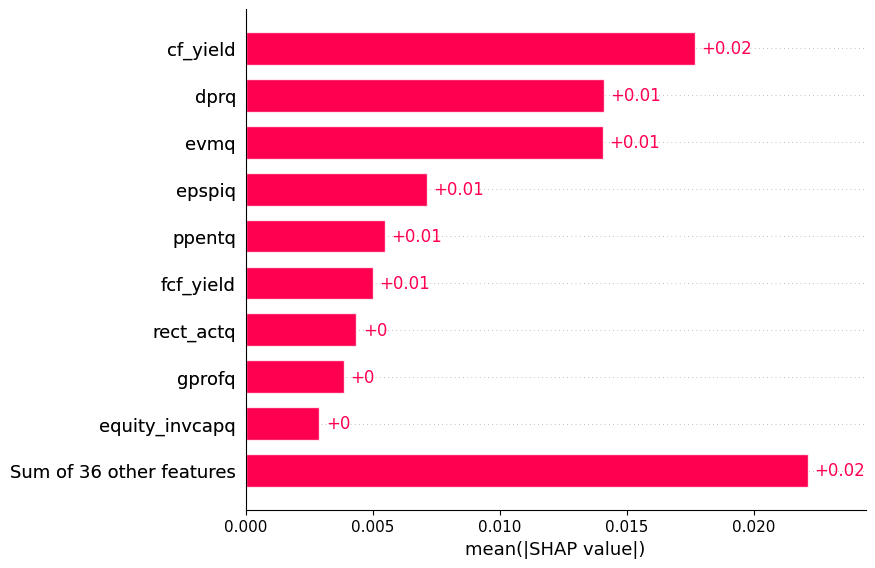

In [94]:
shap.plots.bar(shap_values_DT[:,:-1], max_display=10)

### Decision Tree classifier with non-zero Shapley values

In [95]:
non_zero_shap_values_df(valid_shap_DT, shap_values_DT)

,feature,shap_value
0,dprq,2.371176e-03
6,gprofq,1.125285e-03
14,rect_actq,5.273570e-04
17,prccq,4.579186e-04
22,rectq,3.420073e-04
4,epspiq,3.033318e-04
26,pretret_earnatq,2.664173e-04
28,at_turnq,2.174324e-04
20,atq,2.147469e-04
13,roceq,2.058342e-04


In [96]:
# Optimal features based on Shapley value
DT_shap = non_zero_shap_values_df(valid_shap_DT, shap_values_DT)['feature'].values

In [97]:
# Reduced train dataset (from 2007 to 2009) for the model
train_shap_DT = pd.DataFrame(data = scaler.fit_transform(train[DT_shap].values),columns = DT_shap)
# Reduced validation dataset (from 2007 to 2009) for the model
valid_shap_DT = pd.DataFrame(data = scaler.fit_transform(valid[DT_shap].values),columns = DT_shap)

In [98]:
DT_clf = DecisionTreeClassifier(**study1.best_params, random_state=random_state)
DT_clf.fit(train_shap_DT,y_train)

DecisionTreeClassifier(max_depth=15, min_samples_leaf=200, random_state=123)

In [99]:
# Review the accuracy of the model
DT_train_accuracy = accuracy_score(y_train, DT_clf.predict(train_shap_DT))
DT_valid_accuracy = accuracy_score(y_valid, DT_clf.predict(valid_shap_DT))

print("Train accuracy:", DT_train_accuracy)
print("Validation accuracy:", DT_valid_accuracy)

Train accuracy: 0.4709865805168986
Validation accuracy: 0.3684941013185288


## Shapley values for Logistic Regression classifier

### Shapley values

In [100]:
# Update validation datasets to compute Shapley values
valid_shap_LR = valid_red_LR.copy()
valid_shap_LR['rets'] = df_valid['next_period_return'].values

In [101]:
explainer_LR = shap.explainers.Permutation(lambda features: ret(features = features, model = LR_clf), valid_shap_LR)

In [102]:
shap_values_LR = explainer_LR(valid_shap_LR, max_evals=1000)

PermutationExplainer explainer: 1442it [19:53,  1.20it/s]


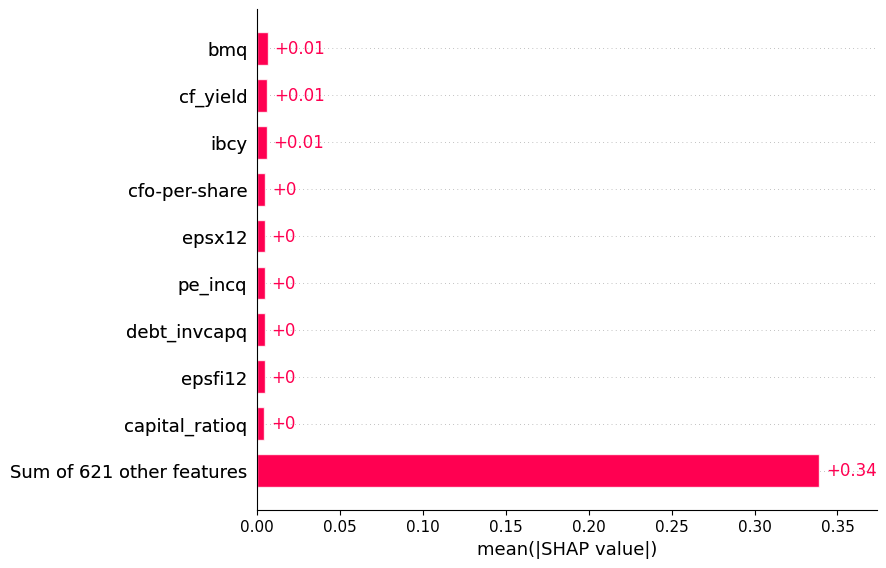

In [103]:
shap.plots.bar(shap_values_LR[:,:-1], max_display=10)

### Train Logistic Regression classifier with non zero Shapley values

In [104]:
non_zero_shap_values_df(valid_shap_LR, shap_values_LR)

,feature,shap_value
274,sector_code_452.0,1.282079e-03
220,spcsrc_B-,1.133477e-03
130,saleq,1.036147e-03
361,actq,1.032401e-03
235,oeps12,1.023551e-03
...,...,...
598,sic_3580,7.684976e-07
157,sic_700,6.356384e-07
144,sector_code_720.0,4.010965e-07
95,sic_2611,2.704025e-07


In [105]:
# Optimal features based on Shapley value
LR_shap = non_zero_shap_values_df(valid_shap_LR, shap_values_LR)['feature'].values

In [106]:
# Reduced train dataset (from 2007 to 2009) for the model
train_shap_LR = pd.DataFrame(data = scaler.fit_transform(train[LR_shap].values),columns = LR_shap)
# Reduced validation dataset (from 2007 to 2009) for the model
valid_shap_LR = pd.DataFrame(data = scaler.fit_transform(valid[LR_shap].values),columns = LR_shap)

In [107]:
LR_clf = LogisticRegression(**study2.best_params, random_state=random_state)
LR_clf.fit(train_shap_LR,y_train)

LogisticRegression(l1_ratio=0.0, random_state=123)

In [108]:
# Review the accuracy of the model
LR_train_accuracy = accuracy_score(y_train, LR_clf.predict(train_shap_LR))
LR_valid_accuracy = accuracy_score(y_valid, LR_clf.predict(valid_shap_LR))

print("Train accuracy:", LR_train_accuracy)
print("Validation accuracy:", LR_valid_accuracy)

Train accuracy: 0.4691227634194831
Validation accuracy: 0.38653712699514226


## Shapley values for Bagging classifier

### Shapley values

In [109]:
# Update validation datasets to compute Shapley values
valid_shap_BG = valid_red_BG.copy()
valid_shap_BG['rets'] = df_valid['next_period_return'].values

In [110]:
explainer_BG = shap.explainers.Permutation(lambda features: ret(features = features, model = BG_clf), valid_shap_BG)

In [111]:
shap_values_BG = explainer_BG(valid_shap_BG, max_evals=300)

PermutationExplainer explainer: 1442it [05:32,  4.21it/s]


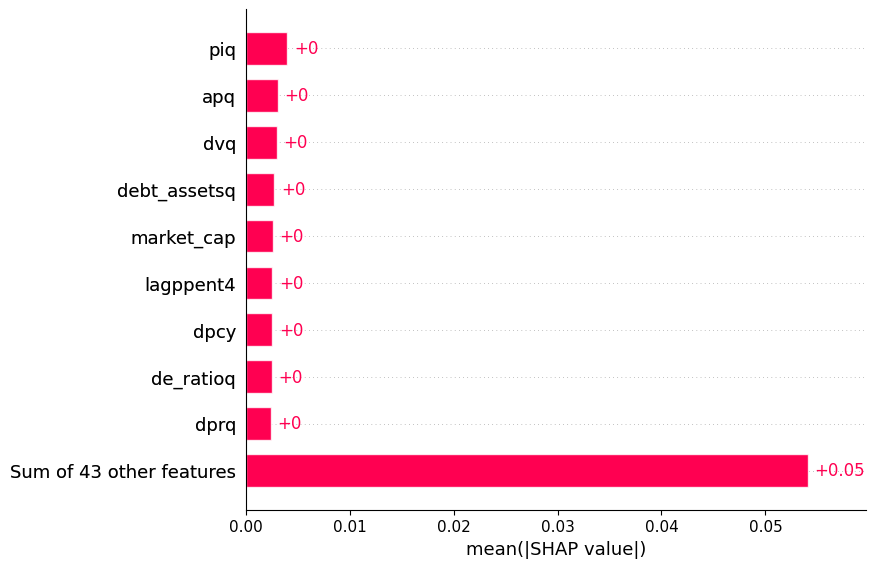

In [112]:
shap.plots.bar(shap_values_BG[:,:-1], max_display=10)

### Train Bagging classifier with non-zero Shapley values

In [113]:
non_zero_shap_values_df(valid_shap_BG, shap_values_BG)

,feature,shap_value
31,lagppent4,5.117137e-04
45,curr_debtq,4.151497e-04
33,invt_actq,2.447752e-04
28,dpcy,2.366687e-04
23,ptpmq,2.165522e-04
46,short_debtq,1.963648e-04
6,accrualq,1.877686e-04
27,dvpspq,1.641781e-04
38,prcraq,1.620953e-04
24,cfmq,1.435915e-04


In [114]:
# Optimal features based on Shapley value
BG_shap = non_zero_shap_values_df(valid_shap_BG, shap_values_BG)['feature'].values

In [115]:
# Reduced train dataset (from 2007 to 2009) for the model
train_shap_BG = pd.DataFrame(data = scaler.fit_transform(train[BG_shap].values),columns = BG_shap)
# Reduced validation dataset (from 2007 to 2009) for the model
valid_shap_BG = pd.DataFrame(data = scaler.fit_transform(valid[BG_shap].values),columns = BG_shap)

In [117]:
BG_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf = study3.best_params["min_samples_leaf"],
                                                                 max_depth = study3.best_params["max_depth"]),
                          n_estimators = study3.best_params["n_estimators"], max_samples = study3.best_params["max_samples"],
                          random_state = random_state)
BG_clf.fit(train_shap_BG, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=15,
                                                        min_samples_leaf=200),
                  max_samples=850, n_estimators=30, random_state=123)

In [118]:
# Review the accuracy of the model
BG_train_accuracy = accuracy_score(y_train, BG_clf.predict(train_shap_BG))
BG_valid_accuracy = accuracy_score(y_valid, BG_clf.predict(valid_shap_BG))

print("Train accuracy:", BG_train_accuracy)
print("Validation accuracy:", BG_valid_accuracy)

Train accuracy: 0.43103876739562624
Validation accuracy: 0.3789035392088827


## Test on all classifiers

In [119]:
# Data to test the performance (from 2010 to 2018)
df_test = data.loc['2010':'2018'].reset_index()
y_test = df_test['rel_performance'].values

test_stock_returns = df_test['next_period_return']

### Accuracy

In [120]:
# For Decision Tree classifier
DT_test_accuracy = accuracy_score(y_test, DT_clf.predict(df_test[DT_shap]))
print("Test accuracy:", DT_test_accuracy)

Test accuracy: 0.47530790027035147


In [121]:
# For Logistic Regression classifier
LR_test_accuracy = accuracy_score(y_test, LR_clf.predict(df_test[LR_shap]))
print("Test accuracy:", LR_test_accuracy)

Test accuracy: 0.4493841994592971


In [122]:
# For Bagging classifier
BG_test_accuracy = accuracy_score(y_test, BG_clf.predict(df_test[BG_shap]))
print("Test accuracy:", BG_test_accuracy)

Test accuracy: 0.4763442475217783


### Confusion matrix

In [123]:
# For Decision Tree classifier
show_confusion_matrix(model = DT_clf, true_values = y_test, values_to_predict = df_test[DT_shap])

,Predicted label -1,Predicted label 0,Predicted label 1
True label -1,1,11536,1630
True label 0,0,29349,2131
True label 1,1,19636,2296


In [124]:
# For Logistic Regression classifier
show_confusion_matrix(model = LR_clf, true_values = y_test, values_to_predict = df_test[LR_shap])

,Predicted label -1,Predicted label 0,Predicted label 1
True label -1,1246,11636,285
True label 0,2739,28232,509
True label 1,1894,19597,442


In [125]:
# For Bagging classifier
show_confusion_matrix(model = BG_clf, true_values = y_test, values_to_predict = df_test[BG_shap])

,Predicted label -1,Predicted label 0,Predicted label 1
True label -1,0,11739,1428
True label 0,0,29700,1780
True label 1,0,19918,2015


### Profit

In [126]:
print("Profit using Decision Trees:", (DT_clf.predict(df_test[DT_shap]) * test_stock_returns).sum())
print("Profit using Logictic Regession:", (LR_clf.predict(df_test[LR_shap]) * test_stock_returns).sum())
print("Profit using Bagging:", (BG_clf.predict(df_test[BG_shap]) * test_stock_returns).sum())

Profit using Decision Trees: 161.82603700000007
Profit using Logictic Regession: -95.46188099999996
Profit using Bagging: 169.43694000000008


In [127]:
# If we were 100% correct on the test set we would get this profit
(y_test * df_test['pred_rel_return']).sum()

5955.172351

# 6. Compute Sharpe Ratio, Information Ratio and alpha for the strategies and for the buy-and-hold strategy for SPY.

## Prepare the data as we did during the lecture

In [128]:
# Use sliding window of 3 years to create time ranges for training the model,
# followed by 3 month test period
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3*i) for i in range(58)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

In [129]:
# Create training and testing subsets
training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
test_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]

In [130]:
# reset the index
training_data = [d.reset_index() for d in training_frames]
test_data = [d.reset_index() for d in test_frames]

In [131]:
# target column
training_labels = [d['rel_performance'].values for d in training_data]

In [132]:
# Select only features according to SHAP approach
# Scale the features
scalers = [StandardScaler() for _ in range(len(training_data))]

# For Decision Tree classifier
opt_training_data_DT = [pd.DataFrame(scalers[i].fit_transform(training_data[i][DT_shap].values),columns=DT_shap) for i in range(len(training_data))]
opt_test_data_DT = [pd.DataFrame(scalers[i].transform(test_data[i][DT_shap].values),columns=DT_shap) for i in range(len(test_data))]

# For Logistic Regression classifier
opt_training_data_LR = [pd.DataFrame(scalers[i].fit_transform(training_data[i][LR_shap].values),columns=LR_shap) for i in range(len(training_data))]
opt_test_data_LR = [pd.DataFrame(scalers[i].transform(test_data[i][LR_shap].values),columns=LR_shap) for i in range(len(test_data))]

# For Bagging classifier
opt_training_data_BG = [pd.DataFrame(scalers[i].fit_transform(training_data[i][BG_shap].values),columns=BG_shap) for i in range(len(training_data))]
opt_test_data_BG = [pd.DataFrame(scalers[i].transform(test_data[i][BG_shap].values),columns=BG_shap) for i in range(len(test_data))]

## Strategies performance

In [133]:
def collect_data(model, opt_training_data, opt_test_data):
  x = [1]
  ret = []

  for i in range(len(start_dates)-1):
        model.fit(opt_training_data[i],training_labels[i])

        preds = model.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x.append(x[i] + (x[i]/num_names)*profit_i)
  return x

In [134]:
# For Decision Tree classifier
DT = collect_data(DT_clf, opt_training_data_DT, opt_test_data_DT)

In [135]:
# For Logistic Regression classifier
LR = collect_data(LR_clf, opt_training_data_LR, opt_test_data_LR)

In [136]:
# For Bagging classifier
BG = collect_data(BG_clf, opt_training_data_BG, opt_test_data_BG)

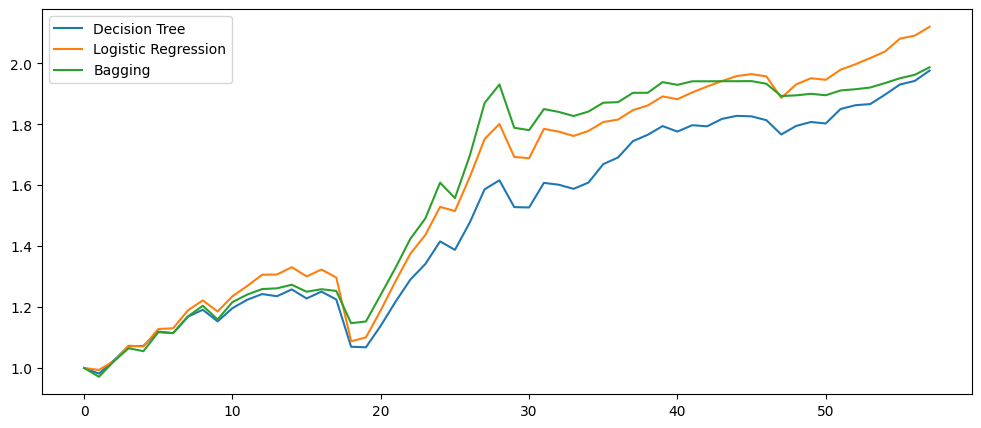

In [137]:
fig = plt.figure(figsize=(12,5))
plt.plot(DT, label = 'Decision Tree')
plt.plot(LR, label = 'Logistic Regression')
plt.plot(BG, label = 'Bagging')
plt.plot
plt.legend()
plt.show()

## Compare to a buy-and-hold of SPY

In [138]:
[x for x in df.columns if 'spy' in x]

['spy_cum_ret', 'spy_next_period_return']

In [139]:
df1 = df.loc['2004-04-01':'2018-09','spy_cum_ret'].reset_index()
SPY = df1[['date','spy_cum_ret']].drop_duplicates().set_index('date')
SPY.head()

,spy_cum_ret
date,
2004-04-01,-0.094754
2004-04-02,-0.087196
2004-04-05,-0.081701
2004-04-06,-0.084911
2004-04-07,-0.087261


In [140]:
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0]+1)
SPY['DT_clf'] = DT
SPY["LR_clf"] = LR
SPY["BG_clf"] = BG

<Axes: xlabel='date'>

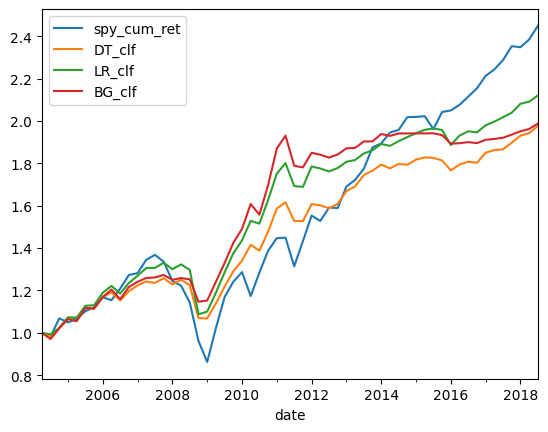

In [141]:
SPY.plot()

## Compute Sharpe Ratio, Information Ratio and alpha for the strategies and for the buy-and-hold strategy for SPY

### Sharpe ratio

In [142]:
# Decision Tree strategy Sharpe Ratio
strategy_mean_ret = (SPY['DT_clf'] - 1).diff().mean()
strategy_std = (SPY['DT_clf'] - 1).diff().std()
print('Decision Tree Strategy Sharpe Ratio: ',strategy_mean_ret/strategy_std)

Decision Tree Strategy Sharpe Ratio:  0.39651875986031276


In [143]:
# Logistic Regression strategy Sharpe Ratio
strategy_mean_ret = (SPY['LR_clf'] - 1).diff().mean()
strategy_std = (SPY['LR_clf'] - 1).diff().std()
print('Logistic Regression Strategy Sharpe Ratio: ',strategy_mean_ret/strategy_std)

Logistic Regression Strategy Sharpe Ratio:  0.3808847436453124


In [144]:
# Bagging strategy Sharpe Ratio
strategy_mean_ret = (SPY['BG_clf'] - 1).diff().mean()
strategy_std = (SPY['BG_clf'] - 1).diff().std()
print('Bagging Strategy Sharpe Ratio: ',strategy_mean_ret/strategy_std)

Bagging Strategy Sharpe Ratio:  0.34029193939809727


In [145]:
# SPY Sharpe Ratio
spy_mean_ret = (SPY['spy_cum_ret'] - 1).diff().mean()
spy_std = (SPY['spy_cum_ret'] - 1).diff().std()
print('SPY Sharpe Ratio: ',spy_mean_ret/spy_std)

SPY Sharpe Ratio:  0.37859996943467217


### Information ratio and $\alpha$ for strategies

In [146]:
strategy_ret_DT = (SPY['DT_clf'] - 1).diff().values[1:]
strategy_ret_LR = (SPY['LR_clf'] - 1).diff().values[1:]
strategy_ret_BG = (SPY['BG_clf'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

In [147]:
beta_DT = (np.cov(spy_ret,strategy_ret_DT)/np.var(spy_ret))[1,0]
beta_LR = (np.cov(spy_ret,strategy_ret_LR)/np.var(spy_ret))[1,0]
beta_BG = (np.cov(spy_ret,strategy_ret_BG)/np.var(spy_ret))[1,0]

In [148]:
residual_ret_DT = strategy_ret_DT - beta_DT * spy_ret
IR_DT = np.mean(residual_ret_DT)/np.std(residual_ret_DT)
print("IR for Decision Tree strategy:", IR_DT)

residual_ret_LR = strategy_ret_LR - beta_LR * spy_ret
IR_LR = np.mean(residual_ret_LR)/np.std(residual_ret_LR)
print("IR for Logistic Regression strategy:", IR_LR)

residual_ret_BG = strategy_ret_BG - beta_BG * spy_ret
IR_BG = np.mean(residual_ret_BG)/np.std(residual_ret_BG)
print("IR for Decision Tree strategy:", IR_BG)

IR for Decision Tree strategy: 0.22036583587082925
IR for Logistic Regression strategy: 0.20430379431123608
IR for Decision Tree strategy: 0.19293184390966978


In [149]:
alpha_DT = np.mean(residual_ret_DT)
print("Alpha for Decision Tree strategy:", alpha_DT)

alpha_LR = np.mean(residual_ret_LR)
print("Alpha for Decision Tree strategy:", alpha_LR)

alpha_BG = np.mean(residual_ret_BG)
print("Alpha for Decision Tree strategy:", alpha_BG)

Alpha for Decision Tree strategy: 0.007825211505675281
Alpha for Decision Tree strategy: 0.008733080672653663
Alpha for Decision Tree strategy: 0.008756885683815132


# 7. Now make a new definition of profit: instead of using an equal weighted portfolio, we weight the portfolio weights with the probabilities of the labels as follows:

Use the _bg_clf.predict_proba_ on the validation set, this will return array of the probabilities $Prob_s (-1)$, $Prob_s (0)$, $Prob_s (1)$ of the labels $-1$, $0$, $1$ for each stock _s_ so an array of dimension _num_stocks_ * $3$. We define the _conviction_ of the model for each presiction as $conviction_s = Prob_s(1) - Prob_s(-1)$ and $weight_s = \frac{conviction_s}{\sum\limits_s |conviction_s|}$ so $\sum\limits_s weight_s = 1$. The profit is then $\sum\limits_s weight_s * next\_period\_return$.

In [171]:
def calculate_profit(model, df, returns, summed = True):
  prob = model.predict_proba(df)

  idx_of_ones = np.where(model.classes_ == 1)[0][0]
  idx_of_neg_ones = np.where(model.classes_ == -1)[0][0]

  conviction = prob[:,idx_of_ones] - prob[:, idx_of_neg_ones]
  weights = conviction/conviction.sum()

  if summed:
    return (weights*returns).sum()
  else:
    return weights*returns

# 8.  Use Optuna and SHAP to find optimal hyperparameters and features, back test and compute Sharpe Ratio.

We can use _train_ and _valid_ sets, defined above

## New objective functions for optuna trainings

In [151]:
def objective_for_DT(trial:Trial, train=None, labels=None, val=None, val_labels=None, val_rets=None):

    min_samples_leaf = trial.suggest_int('min_samples_leaf', 200, 1000, step=100)
    max_depth = trial.suggest_int('max_depth', 5, 25, step=5)

    DT_clf = DecisionTreeClassifier(min_samples_leaf = min_samples_leaf,
                                   max_depth = max_depth,
                                   random_state = random_state)
    DT_clf.fit(train, labels)
    return calculate_profit(DT_clf, val, val_rets)

In [152]:
def objective_for_LR(trial:Trial, train=None, labels=None, val=None, val_labels=None, val_rets=None):

      l1_ratio = trial.suggest_float("l1_ratio", 0, 1, step = 0.01)

      LR_clf = LogisticRegression(l1_ratio = l1_ratio, random_state = random_state)

      LR_clf.fit(train, labels)
      return calculate_profit(LR_clf, val, val_rets)

In [153]:
def objective_for_BG(trial:Trial, train=None, labels=None, val=None, val_labels=None, val_rets=None):

    min_samples_leaf = trial.suggest_int('min_samples_leaf', 200, 1000, step=100)
    max_depth = trial.suggest_int('max_depth', 5, 25, step=5)
    max_samples = trial.suggest_int('max_samples', 50, 1000, step=50)
    n_estimators = trial.suggest_int('n_estimators', 10, 50, step=5)

    BG_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf = min_samples_leaf, max_depth = max_depth),
                               n_estimators = n_estimators, max_samples = max_samples, random_state = random_state)
    BG_clf.fit(train, labels)
    return calculate_profit(BG_clf, val, val_rets)

## Decision Tree classifier

### Model training

In [154]:
study1 = optuna.create_study(direction="maximize")
study1.optimize(partial(objective_for_DT, train=train, labels=y_train, val=valid, val_labels=y_valid, val_rets=valid_stock_returns.values), n_trials=n_trials, n_jobs=-1)

[I 2023-12-10 23:53:41,457] A new study created in memory with name: no-name-1daf842f-5701-4fb3-9e45-891f28648f66
[I 2023-12-10 23:53:44,753] Trial 0 finished with value: -0.034303511662178626 and parameters: {'min_samples_leaf': 1000, 'max_depth': 15}. Best is trial 0 with value: -0.034303511662178626.
[I 2023-12-10 23:53:45,142] Trial 1 finished with value: -0.03415515001752346 and parameters: {'min_samples_leaf': 600, 'max_depth': 15}. Best is trial 1 with value: -0.03415515001752346.
[I 2023-12-10 23:53:47,447] Trial 2 finished with value: -0.031873555991142985 and parameters: {'min_samples_leaf': 500, 'max_depth': 10}. Best is trial 2 with value: -0.031873555991142985.
[I 2023-12-10 23:53:47,968] Trial 3 finished with value: -0.03430701885808313 and parameters: {'min_samples_leaf': 400, 'max_depth': 25}. Best is trial 2 with value: -0.031873555991142985.
[I 2023-12-10 23:53:49,981] Trial 4 finished with value: -0.03403380784730374 and parameters: {'min_samples_leaf': 300, 'max_dep

In [155]:
DT_clf = DecisionTreeClassifier(**study1.best_params, random_state=random_state)
DT_clf.fit(train,y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=200, random_state=123)

In [156]:
# Review the accuracy of the model
DT_train_accuracy = accuracy_score(y_train, DT_clf.predict(train))
DT_valid_accuracy = accuracy_score(y_valid, DT_clf.predict(valid))

print("Train accuracy:", DT_train_accuracy)
print("Validation accuracy:", DT_valid_accuracy)

Train accuracy: 0.4821694831013916
Validation accuracy: 0.3657182512144344


### Remove not important features

In [157]:
# Important features for Decision Tree classifier
DT_fi = tree_feature_importance(model = DT_clf, model_name = "DT", df = train)
DT_features = DT_fi[(DT_fi['feat_imp'] > 0.00)]
DT_features

,cols,feat_imp
108,dprq,0.111742
105,cf_yield,0.080703
95,evmq,0.072593
156,fcf_yield,0.060971
22,epspiq,0.047331
173,sale_invcapq,0.041007
136,gprofq,0.036526
50,req,0.028906
58,txpq,0.026332
80,txpdy,0.025646


In [158]:
# Optimal features
DT_cols = DT_features['cols'].values

# Reduced train dataset for the model
train_red_DT = pd.DataFrame(data = scaler.fit_transform(train[DT_cols].values),columns = DT_cols)

# Reduced validation dataset for the model
valid_red_DT = pd.DataFrame(data = scaler.fit_transform(valid[DT_cols].values),columns = DT_cols)

train_stock_returns = df_train['next_period_return']
valid_stock_returns = df_valid['next_period_return']

In [163]:
DT_clf = DecisionTreeClassifier(**study1.best_params, random_state=random_state)
DT_clf.fit(train_red_DT,y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=200, random_state=123)

### Shapley values

In [172]:
# Updated ret function based on the new definition of return
def ret_new(features, model):
    clf_features = features[features.columns[:-1].values]
    return calculate_profit(model, clf_features, features[features.columns[-1]], summed = False)

In [173]:
# Update validation datasets to compute Shapley values
valid_shap_DT = valid_red_DT.copy()
valid_shap_DT['rets'] = df_valid['next_period_return'].values

In [174]:
explainer_DT = shap.explainers.Permutation(lambda features: ret_new(features = features, model = DT_clf), valid_shap_DT)
shap_values_DT = explainer_DT(valid_shap_DT, max_evals=200)

PermutationExplainer explainer: 1442it [00:47, 23.92it/s]


### Retrain Decision Tree for features with non-zero Shapley value

In [175]:
non_zero_shap_values_df(valid_shap_DT, shap_values_DT)

,feature,shap_value
0,dprq,4.516626e-07
1,cf_yield,3.598306e-07
6,gprofq,2.816910e-07
17,prccq,1.172756e-07
28,at_turnq,1.045953e-07
22,rectq,7.900208e-08
5,sale_invcapq,7.845531e-08
14,rect_actq,7.352074e-08
20,atq,5.621645e-08
38,quick_ratioq,4.135201e-08


In [176]:
# Optimal features based on Shapley value
DT_shap = non_zero_shap_values_df(valid_shap_DT, shap_values_DT)['feature'].values
# Reduced train dataset for the model
train_shap_DT = pd.DataFrame(data = scaler.fit_transform(train[DT_shap].values),columns = DT_shap)
# Reduced validation dataset for the model
valid_shap_DT = pd.DataFrame(data = scaler.fit_transform(valid[DT_shap].values),columns = DT_shap)

In [177]:
DT_clf = DecisionTreeClassifier(**study1.best_params, random_state=random_state)
DT_clf.fit(train_shap_DT,y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=200, random_state=123)

## Logistic Regression classifier

### Model training

In [178]:
study2 = optuna.create_study(direction="maximize")
study2.optimize(partial(objective_for_LR, train=train, labels=y_train, val=valid, val_labels=y_valid, val_rets=valid_stock_returns.values), n_trials=n_trials, n_jobs=-1)

[I 2023-12-11 00:10:40,936] A new study created in memory with name: no-name-0e89f32b-6e03-46ed-99da-e82e661bb0d0
[I 2023-12-11 00:11:02,658] Trial 1 finished with value: -0.021637709293328374 and parameters: {'l1_ratio': 0.9400000000000001}. Best is trial 1 with value: -0.021637709293328374.
[I 2023-12-11 00:11:02,696] Trial 0 finished with value: -0.021637709293328374 and parameters: {'l1_ratio': 0.15}. Best is trial 1 with value: -0.021637709293328374.
[I 2023-12-11 00:11:23,183] Trial 2 finished with value: -0.021637709293328374 and parameters: {'l1_ratio': 0.9500000000000001}. Best is trial 1 with value: -0.021637709293328374.
[I 2023-12-11 00:11:23,210] Trial 3 finished with value: -0.021637709293328374 and parameters: {'l1_ratio': 0.09}. Best is trial 1 with value: -0.021637709293328374.
[I 2023-12-11 00:11:45,893] Trial 4 finished with value: -0.021637709293328374 and parameters: {'l1_ratio': 0.19}. Best is trial 1 with value: -0.021637709293328374.
[I 2023-12-11 00:11:45,909] 

In [179]:
LR_clf = LogisticRegression(**study2.best_params, random_state=random_state)
LR_clf.fit(train,y_train)

LogisticRegression(l1_ratio=0.9400000000000001, random_state=123)

In [180]:
# Review the accuracy of the model
LR_train_accuracy = accuracy_score(y_train, LR_clf.predict(train))
LR_valid_accuracy = accuracy_score(y_valid, LR_clf.predict(valid))

print("Train accuracy:", LR_train_accuracy)
print("Validation accuracy:", LR_valid_accuracy)

Train accuracy: 0.48533797216699803
Validation accuracy: 0.39070090215128384


### Remove not important features

In [181]:
# Important features for Logistic Regression classifier
LR_fi = tree_feature_importance(model = LR_clf, model_name = "LR", df = train)
LR_features = LR_fi[(LR_fi['feat_imp'] > 0.00)]
LR_features

,cols,feat_imp
598,spcsrc_A+,0.446765
491,sic_5900,0.433719
273,sic_2870,0.404469
532,sic_6794,0.393248
196,sic_1531,0.365595
...,...,...
137,equity_invcapq,0.004703
57,txditcq,0.004014
158,lt_ppentq,0.002792
148,short_debtq,0.002280


In [182]:
# Optimal features
LR_cols = LR_features['cols'].values

# Reduced train dataset for the model
train_red_LR = pd.DataFrame(data = scaler.fit_transform(train[LR_cols].values),columns = LR_cols)

# Reduced validation dataset for the model
valid_red_LR = pd.DataFrame(data = scaler.fit_transform(valid[LR_cols].values),columns = LR_cols)

train_stock_returns = df_train['next_period_return']
valid_stock_returns = df_valid['next_period_return']

In [183]:
LR_clf = LogisticRegression(**study2.best_params, random_state=random_state)
LR_clf.fit(train_red_LR,y_train)

LogisticRegression(l1_ratio=0.9400000000000001, random_state=123)

### Shapley values

In [184]:
# Update validation datasets to compute Shapley values
valid_shap_LR = valid_red_LR.copy()
valid_shap_LR['rets'] = df_valid['next_period_return'].values

In [185]:
explainer_LR = shap.explainers.Permutation(lambda features: ret_new(features = features, model = LR_clf), valid_shap_LR)
shap_values_LR = explainer_LR(valid_shap_LR, max_evals=1000)

PermutationExplainer explainer: 1442it [20:32,  1.16it/s]


### Retrain Logistic Regression for features with non-zero Shapley value

In [186]:
non_zero_shap_values_df(valid_shap_LR, shap_values_LR)

,feature,shap_value
34,sic_3270,4.529760e-07
108,ltq,3.368203e-07
385,bmq,2.771700e-07
198,sic_3751,2.589499e-07
248,epsx12,2.056121e-07
...,...,...
263,sic_2111,3.945083e-11
423,sic_3564,3.918506e-11
190,sic_2033,3.284902e-11
539,sector_code_310.0,3.089706e-11


In [187]:
# Optimal features based on Shapley value
LR_shap = non_zero_shap_values_df(valid_shap_LR, shap_values_LR)['feature'].values
# Reduced train dataset for the model
train_shap_LR = pd.DataFrame(data = scaler.fit_transform(train[LR_shap].values),columns = LR_shap)
# Reduced validation dataset for the model
valid_shap_LR = pd.DataFrame(data = scaler.fit_transform(valid[LR_shap].values),columns = LR_shap)

In [188]:
LR_clf = LogisticRegression(**study2.best_params, random_state=random_state)
LR_clf.fit(train_shap_LR,y_train)

LogisticRegression(l1_ratio=0.9400000000000001, random_state=123)

## Bagging classifier

### Model training

In [189]:
study3 = optuna.create_study(direction="maximize")
study3.optimize(partial(objective_for_BG, train=train, labels=y_train, val=valid, val_labels=y_valid, val_rets=valid_stock_returns.values), n_trials=n_trials, n_jobs=-1)

[I 2023-12-11 00:40:40,188] A new study created in memory with name: no-name-7e8521d4-d090-4140-aff7-11e6099a13d2
[I 2023-12-11 00:40:42,447] Trial 1 finished with value: -0.03218124149895911 and parameters: {'min_samples_leaf': 700, 'max_depth': 20, 'max_samples': 150, 'n_estimators': 40}. Best is trial 1 with value: -0.03218124149895911.
[I 2023-12-11 00:40:42,467] Trial 0 finished with value: -0.032181241498959096 and parameters: {'min_samples_leaf': 700, 'max_depth': 20, 'max_samples': 800, 'n_estimators': 40}. Best is trial 0 with value: -0.032181241498959096.
[I 2023-12-11 00:40:44,366] Trial 2 finished with value: -0.032181241498959096 and parameters: {'min_samples_leaf': 600, 'max_depth': 25, 'max_samples': 100, 'n_estimators': 35}. Best is trial 0 with value: -0.032181241498959096.
[I 2023-12-11 00:40:44,719] Trial 3 finished with value: -0.03218124149895911 and parameters: {'min_samples_leaf': 700, 'max_depth': 20, 'max_samples': 150, 'n_estimators': 40}. Best is trial 0 with

In [190]:
BG_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf = study3.best_params["min_samples_leaf"],
                                                                 max_depth = study3.best_params["max_depth"]),
                          n_estimators = study3.best_params["n_estimators"], max_samples = study3.best_params["max_samples"],
                          random_state = random_state)
BG_clf.fit(train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                        min_samples_leaf=200),
                  max_samples=1000, n_estimators=15, random_state=123)

In [191]:
# Review the accuracy of the model
BG_train_accuracy = accuracy_score(y_train, BG_clf.predict(train))
BG_valid_accuracy = accuracy_score(y_valid, BG_clf.predict(valid))

print("Train accuracy:", BG_train_accuracy)
print("Validation accuracy:", BG_valid_accuracy)

Train accuracy: 0.43395874751491054
Validation accuracy: 0.38584316446911865


### Remove not important features

In [192]:
# Important features for Bagging classifier
BG_fi = tree_feature_importance(model = BG_clf, model_name = "BG", df = train)
BG_features = BG_fi[(BG_fi['feat_imp'] > 0.00)]
BG_features

,cols,feat_imp
107,dvq,0.068482
162,de_ratioq,0.052234
147,debt_ebitdaq,0.044479
86,dvpspq,0.043069
30,invtq,0.042678
64,capxy,0.041228
164,intcov_ratioq,0.040844
113,ptpmq,0.037177
156,fcf_yield,0.033538
36,nopiq,0.033442


In [193]:
# Optimal features
BG_cols = BG_features['cols'].values

# Reduced train dataset for the model
train_red_BG = pd.DataFrame(data = scaler.fit_transform(train[BG_cols].values),columns = BG_cols)

# Reduced validation dataset for the model
valid_red_BG = pd.DataFrame(data = scaler.fit_transform(valid[BG_cols].values),columns = BG_cols)

train_stock_returns = df_train['next_period_return']
valid_stock_returns = df_valid['next_period_return']

In [194]:
BG_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf = study3.best_params["min_samples_leaf"],
                                                                 max_depth = study3.best_params["max_depth"]),
                          n_estimators = study3.best_params["n_estimators"], max_samples = study3.best_params["max_samples"],
                          random_state = random_state)

BG_clf.fit(train_red_BG, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                        min_samples_leaf=200),
                  max_samples=1000, n_estimators=15, random_state=123)

### Shapley values

In [195]:
# Update validation datasets to compute Shapley values
valid_shap_BG = valid_red_BG.copy()
valid_shap_BG['rets'] = df_valid['next_period_return'].values

In [196]:
explainer_BG = shap.explainers.Permutation(lambda features: ret_new(features = features, model = BG_clf), valid_shap_BG)
shap_values_BG = explainer_BG(valid_shap_BG, max_evals=300)

PermutationExplainer explainer: 1442it [03:18,  6.85it/s]


### Retrain Bagging for features with non-zero Shapley values

In [197]:
non_zero_shap_values_df(valid_shap_BG, shap_values_BG)

,feature,shap_value
14,txpq,7.252008e-08
8,fcf_yield,4.835935e-08
17,debt_assetsq,4.293692e-08
2,debt_ebitdaq,2.566426e-08
33,dprq,1.537965e-08
32,ibcy,1.071966e-08
0,dvq,1.040439e-08
29,roceq,7.984916e-09
3,dvpspq,7.900241e-09
23,invt_actq,6.104464e-09


In [198]:
# Optimal features based on Shapley value
BG_shap = non_zero_shap_values_df(valid_shap_BG, shap_values_BG)['feature'].values
# Reduced train dataset for the model
train_shap_BG = pd.DataFrame(data = scaler.fit_transform(train[BG_shap].values),columns = BG_shap)
# Reduced validation dataset for the model
valid_shap_BG = pd.DataFrame(data = scaler.fit_transform(valid[BG_shap].values),columns = BG_shap)

In [199]:
BG_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf = study3.best_params["min_samples_leaf"],
                                                                 max_depth = study3.best_params["max_depth"]),
                          n_estimators = study3.best_params["n_estimators"], max_samples = study3.best_params["max_samples"],
                          random_state = random_state)
BG_clf.fit(train_shap_BG, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                        min_samples_leaf=200),
                  max_samples=1000, n_estimators=15, random_state=123)

## Back test for all classifiers

In [200]:
# Data to test the performance (from 2010 to 2018)
df_test = data.loc['2010':'2018'].reset_index()
y_test = df_test['rel_performance'].values

test_stock_returns = df_test['next_period_return']

### Accuracy

In [201]:
# For Decision Tree classifier
DT_test_accuracy = accuracy_score(y_test, DT_clf.predict(df_test[DT_shap]))
print("Test accuracy:", DT_test_accuracy)

Test accuracy: 0.33164613998197656


In [202]:
# For Logistic Regression classifier
LR_test_accuracy = accuracy_score(y_test, LR_clf.predict(df_test[LR_shap]))
print("Test accuracy:", LR_test_accuracy)

Test accuracy: 0.40129167918293784


In [203]:
# For Bagging classifier
BG_test_accuracy = accuracy_score(y_test, BG_clf.predict(df_test[BG_shap]))
print("Test accuracy:", BG_test_accuracy)

Test accuracy: 0.4748272754580955


### Confusion matrix

In [204]:
# For Decision Tree classifier
show_confusion_matrix(model = DT_clf, true_values = y_test, values_to_predict = df_test[DT_shap])

,Predicted label -1,Predicted label 0,Predicted label 1
True label -1,0,1247,11920
True label 0,0,1588,29892
True label 1,0,1440,20493


In [205]:
# For Logistic Regression classifier
show_confusion_matrix(model = LR_clf, true_values = y_test, values_to_predict = df_test[LR_shap])

,Predicted label -1,Predicted label 0,Predicted label 1
True label -1,2731,10154,282
True label 0,7577,23582,321
True label 1,4350,17178,405


In [206]:
# For Bagging classifier
show_confusion_matrix(model = BG_clf, true_values = y_test, values_to_predict = df_test[BG_shap])

,Predicted label -1,Predicted label 0,Predicted label 1
True label -1,0,12825,342
True label 0,0,31085,395
True label 1,0,21404,529


### Profit

In [207]:
print("Profit using Decision Trees:", calculate_profit(DT_clf, df_test[DT_shap], test_stock_returns))
print("Profit using Logictic Regession:", calculate_profit(LR_clf, df_test[LR_shap], test_stock_returns))
print("Profit using Bagging:", calculate_profit(BG_clf, df_test[BG_shap], test_stock_returns))

Profit using Decision Trees: 0.029176368789031456
Profit using Logictic Regession: 0.021389873929062747
Profit using Bagging: 0.028896278555108165


## Sharpe ratio

In [209]:
# For Decision Tree classifier
opt_training_data_DT = [pd.DataFrame(scalers[i].fit_transform(training_data[i][DT_shap].values),columns=DT_shap) for i in range(len(training_data))]
opt_test_data_DT = [pd.DataFrame(scalers[i].transform(test_data[i][DT_shap].values),columns=DT_shap) for i in range(len(test_data))]

# For Logistic Regression classifier
opt_training_data_LR = [pd.DataFrame(scalers[i].fit_transform(training_data[i][LR_shap].values),columns=LR_shap) for i in range(len(training_data))]
opt_test_data_LR = [pd.DataFrame(scalers[i].transform(test_data[i][LR_shap].values),columns=LR_shap) for i in range(len(test_data))]

# For Bagging classifier
opt_training_data_BG = [pd.DataFrame(scalers[i].fit_transform(training_data[i][BG_shap].values),columns=BG_shap) for i in range(len(training_data))]
opt_test_data_BG = [pd.DataFrame(scalers[i].transform(test_data[i][BG_shap].values),columns=BG_shap) for i in range(len(test_data))]

In [210]:
# Updated function based on the profit definition
def collect_data_new(model, opt_training_data, opt_test_data):
  x = [1]
  ret = []

  for i in range(len(start_dates)-1):
        model.fit(opt_training_data[i],training_labels[i])

        profit_i = calculate_profit(model, opt_test_data[i], test_frames[i]['next_period_return'])
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x.append(x[i] + (x[i]/num_names)*profit_i)
  return x

In [211]:
# For Decision Tree classifier
DT = collect_data_new(DT_clf, opt_training_data_DT, opt_test_data_DT)

# For Logistic Regression classifier
LR = collect_data_new(LR_clf, opt_training_data_LR, opt_test_data_LR)

# For Bagging classifier
BG = collect_data_new(BG_clf, opt_training_data_BG, opt_test_data_BG)

In [212]:
df1 = df.loc['2004-04-01':'2018-09','spy_cum_ret'].reset_index()
SPY = df1[['date','spy_cum_ret']].drop_duplicates().set_index('date')

SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0]+1)
SPY['DT_clf'] = DT
SPY["LR_clf"] = LR
SPY["BG_clf"] = BG

In [214]:
# Decision Tree strategy Sharpe Ratio
strategy_mean_ret = (SPY['DT_clf'] - 1).diff().mean()
strategy_std = (SPY['DT_clf'] - 1).diff().std()
print('Decision Tree Strategy Sharpe Ratio: ',strategy_mean_ret/strategy_std)

Decision Tree Strategy Sharpe Ratio:  0.40979246055467705


In [215]:
# Logistic Regression strategy Sharpe Ratio
strategy_mean_ret = (SPY['LR_clf'] - 1).diff().mean()
strategy_std = (SPY['LR_clf'] - 1).diff().std()
print('Logistic Regression Strategy Sharpe Ratio: ',strategy_mean_ret/strategy_std)

Logistic Regression Strategy Sharpe Ratio:  0.43186059575337404


In [216]:
# Bagging strategy Sharpe Ratio
strategy_mean_ret = (SPY['BG_clf'] - 1).diff().mean()
strategy_std = (SPY['BG_clf'] - 1).diff().std()
print('Bagging Strategy Sharpe Ratio: ',strategy_mean_ret/strategy_std)

Bagging Strategy Sharpe Ratio:  0.4032094930949797


In [217]:
# SPY Sharpe Ratio
spy_mean_ret = (SPY['spy_cum_ret'] - 1).diff().mean()
spy_std = (SPY['spy_cum_ret'] - 1).diff().std()
print('SPY Sharpe Ratio: ',spy_mean_ret/spy_std)

SPY Sharpe Ratio:  0.37859996943467217
